<a href="https://colab.research.google.com/github/olalepek/Text-Mining---Agriculture/blob/main/%5BMain%5D_Agriculture_Text_Mining_SOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOW TO CULTIVATE YOUR FIELD

This project conducts a comprehensive **analysis of the impact of tillage practices on Soil Organic Carbon (SOC)** through the review of abstracts from scientific publications. **Using various text mining and sentiment analysis techniques**, the project explores the findings of published research to quantify the effects of minimum tillage compared to conventional tillage practices. From preprocessing to modeling, each step is designed to extract  insights into how tillage practices influence SOC, setting the stage for broader investigations into agricultural practices' environmental impacts.

## Preparation


> **Setup**: This section prepares the environment by importing necessary libraries and setting up prerequisites for the analysis.

> **Preprocessing**: Focuses on cleaning and preparing the data for analysis, including text normalization and tokenization.

>**Lemmatized Text & Porter Stemmer**: Demonstrates the process of lemmatizing the text to its base form to ensure consistency in analysis. Then comparing Lemmatized Abstract with Porter Stemmer Compares the effectiveness of lemmatization versus stemming.


## Models

>**Topic Modelling from Abstracts**: Applies topic modeling techniques to classify abstracts into different themes related to agriculture in general.
Then assigning dominant topic to each article to be able to classify them.

> **TF-IDF (Term Frequency-Inverse Document Frequency)**: Utilizes TF-IDF to highlight the importance of specific words and phrases in the corpus.

> **Apriori Model to Count the Words & Word Cloud**: Employs the Apriori model for word frequency analysis and visualizes the results through a word cloud

## Rule Based Matching

> **Pattern/Entity recognition** Updating the ents dictionary with the mapping provided to iclude words and phrases connected to the agriculture and the project topic. Then identifing words and phrases that indicate effect of the practice (increse or decrease) on soil componen based on the dictionary provided.

> **Finiding matches based on entity recognition**: Based on earlier identified entities creating matcher that will select the articles that INCREASED SOC and are connected to MINIMSL/NO TILLAGE practices

## Results
From **17875 only 244 (1%)** articles were identified as connected to Minimal/No Tillage practices impact on increasing Soil Organic Carbon. However this result needs to be further verified as there are potential matches missing or also mismatches in this set.










# Setup

In [1]:
!pip install rispy pandas
!pip install plotly

In [2]:
#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import rispy
!python -m spacy download en_core_web_sm
import spacy
import re
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler
from spacy.matcher import DependencyMatcher
from spacy.matcher import PhraseMatcher
import plotly.express as px
import ast


#dataset['country'] = dataset['country'].apply(ast.literal_eval)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 100.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Function definitions


In [60]:
def pie_chart_characteristics_legend(characteristic, dataset):

    filtered_df = dataset[dataset[characteristic].apply(lambda x: len(x) > 0)]
    category_item = pd.Series([item for sublist in filtered_df[characteristic] for item in sublist])
    category_counts = category_item.value_counts()
    total = sum(category_counts)

    plt.figure(figsize=(10, 7))
    wedges, texts, autotexts = plt.pie(category_counts, labels=category_counts.index, startangle=140, autopct="")

    labels = [f'{label} - {count} ({(count/total)*100:.1f}%)' for label, count in zip(category_counts.index, category_counts)]

    plt.title(f'{characteristic} Distribution')

    plt.legend(wedges, labels, title=f'{characteristic} Summary', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [ ]:
def find_matches_for_characteristics (characteristic,excel,sheet,column1,column2,dataset):
  xls = pd.ExcelFile(excel)
  print("List of all sheets in the excel file loaded: " + str(xls.sheet_names))
  matches_df = pd.read_excel(excel, sheet_name=sheet)
  characteristics = []
  characteristics = matches_df.iloc[:, 0].tolist()
  characteristics = [match.lower() for match in characteristics]
  print("List of characteristics " + str(characteristics))

  nlp = spacy.load("en_core_web_sm")
  matcher = PhraseMatcher(nlp.vocab)
  terms = characteristics
  patterns = [nlp.make_doc(text) for text in terms]
  matcher.add("TerminologyList", patterns)

  def find_matches(column1,column2):
      text = column1 + " " + column2

      doc = nlp(text)
      matches = matcher(doc)
      matched_terms = {doc[start:end].text for match_id, start, end in matches}
      return list(matched_terms)

  dataset[characteristic] =dataset.apply(lambda row: find_matches(row[column1], row[column2]), axis=1)

  return dataset.head(1)

In [ ]:
def pie_chart_characteristics (characteristic,dataset):
  filtered_df = dataset[dataset[characteristic].apply(lambda x: len(x) > 0)]
  filtered_df.info()

  category_item = pd.Series([item for sublist in filtered_df[characteristic] for item in sublist])

  category_counts = category_item.value_counts()

  plt.figure(figsize=(10, 7))  # Adjust the size of the figure as needed
  plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

  plt.title(characteristic + 'Distribution')

  # Show the pie chart
  return plt.show()

In [45]:
def country_map(column,dataset):
  category_item = pd.Series([item for sublist in dataset[column] for item in sublist])

  country_counts = category_item.value_counts().reset_index()
  country_counts.columns = ['Country', 'Counts']
  fig = px.choropleth(country_counts,
                    locations='Country',
                    locationmode='country names',
                    hover_name="Country",
                    hover_data={"Counts": True},
                    color='Counts',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Country Counts')
  return fig.show()


In [ ]:
def patterns_from_excel (rules, rules_sheet):
  rules_df = pd.read_excel(rules, sheet_name=rules_sheet)
  rules_df.columns=["Label", "Pattern"]
  rules_pattern = [{"label": row["Label"], "pattern": row["Pattern"]} for index, row in rules_df.iterrows()]
  print("list of patterns identified ")
  return rules_pattern

In [ ]:
def set_entity_ruler (nlp, rules, rules_sheet, patterns, dataset, column_to_analyze,output_col_name):

  rules_df = pd.read_excel(rules, sheet_name=rules_sheet)
  rules_df.columns=["Label", "Pattern"]
  rules_pattern = [{"label": row["Label"], "pattern": row["Pattern"]} for index, row in rules_df.iterrows()]
  print("list of patterns identified " + str(patterns))
  ruler = nlp.add_pipe("entity_ruler", before = "ner")
  ruler.add_patterns(rules_pattern)
  ruler.add_patterns(patterns)

  ruler_patterns = ruler.patterns

  dataset[output_col_name] = dataset[column_to_analyze].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])


  return dataset.head(1)

In [ ]:
def matcher(text):
    doc = nlp(text)
    matches = matcher(doc)
    match_texts = []
    for match_id, token_ids in matches:
        match_text = ' '.join([doc[i].text for i in token_ids])
        match_texts.append(match_text)
    return match_texts


In [ ]:
def regular_matcher(nlp, dataset, column_to_analyze, new_column, patterns, label):

    matcher = Matcher(nlp.vocab)
    for pattern_name, pattern in patterns.items():
        matcher.add(pattern_name, [pattern])

    def apply_matcher(text):
        doc = nlp(text)
        matches = matcher(doc)
        return [doc[start:end].text for _, start, end in matches]

    dataset[new_column] = dataset[column_to_analyze].apply(apply_matcher)
    return dataset

In [84]:
def filter_label(entity_label_list, interested_labels):
    unique_labels = {label for _, label in entity_label_list if label in interested_labels}
    return list(unique_labels)



In [ ]:
def dependency_matcher(nlp, patterns, dataset, column_name_to_match, new_column):
    matcher = DependencyMatcher(nlp.vocab)
    for pattern_name, pattern in patterns.items():
      matcher.add("Pattern",[patterns])

    def apply_matcher(text):
        doc = nlp(text)
        matches = matcher(doc)
        match_texts = []
        for match_id, token_ids in matches:
            match_text = ' '.join(doc[i].text for i in token_ids)
            match_texts.append(match_text)
        return match_texts

    dataset[new_column] = dataset[column_name_to_match].apply(apply_matcher)
    return dataset.head(1)

In [ ]:
def timeline_of_phrases_used_articles(dataframe, column_with_phrases, year_column, phrases_as_list):
    df_list = []

    for phrase in phrases_as_list:
        mask = dataframe[column_with_phrases].str.contains(phrase, case=False, na=False)
        df_filtered = dataframe[mask]
        counts_per_year = df_filtered.groupby(year_column).size().reset_index(name='article_count')
        counts_per_year['Term'] = phrase
        df_list.append(counts_per_year)
    combined_counts = pd.concat(df_list)

    fig = px.line(combined_counts, x=year_column, y='article_count', color='Term',
                  title='Article Count Over Years for Each Term',
                  markers=True)

    fig.update_layout(xaxis_title='Year', yaxis_title='Article Count', legend_title="Term")
    fig.show()



In [ ]:
def count_values_non_empty_column(columns_of_interest, dataset):

  unique_counts = {}
  for column in columns_of_interest:
      # Count non-empty lists in each column
      non_empty_lists = dataset[column].apply(lambda x: len(x) > 0)
      unique_counts[column] = non_empty_lists.sum()
  return unique_counts


In [ ]:
def pie_chart_column_count (unique_counts, title):

  labels = unique_counts.keys()
  sizes = unique_counts.values()

  # Plotting the pie chart
  fig, ax = plt.subplots()
  ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
  ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

  # Display the pie chart
  plt.title(title)
  plt.show()

# Basic Analysis of the whole dataset

Based on the matching keywords or phrases coming from the terminology excel to the abstracts.

In [12]:
dataset = pd.read_csv('/content/drive/MyDrive/Studia DSE/all_data_combined.csv')

In [51]:
dataset['country'] = dataset['country'].apply(ast.literal_eval)

Distribution of each of the characteristics (soil, climate, crop, country) within the whole dataset

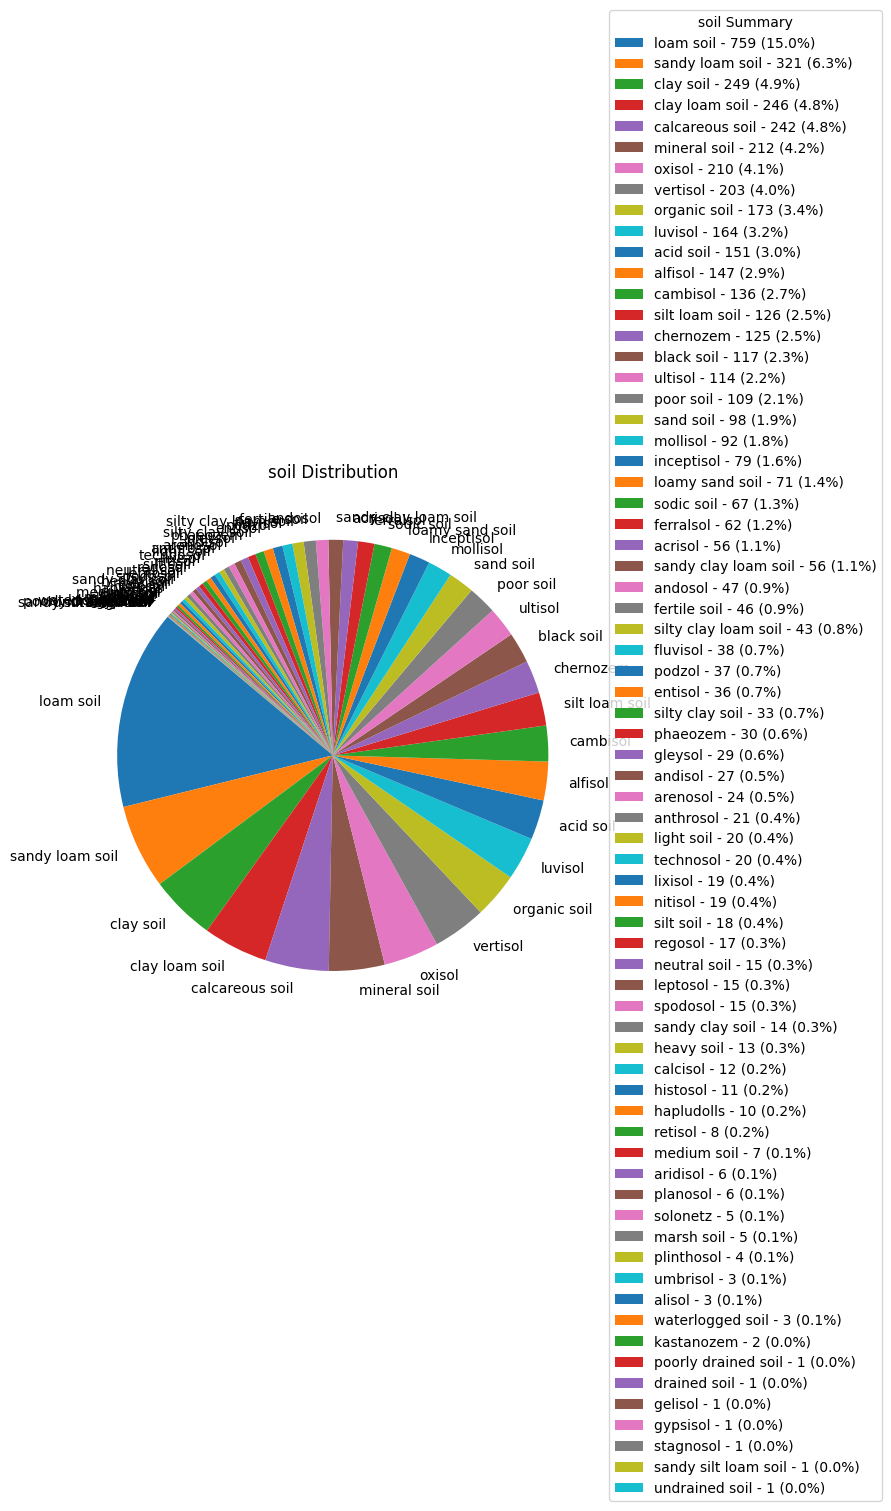

In [61]:
pie_chart_characteristics_legend('soil',dataset)


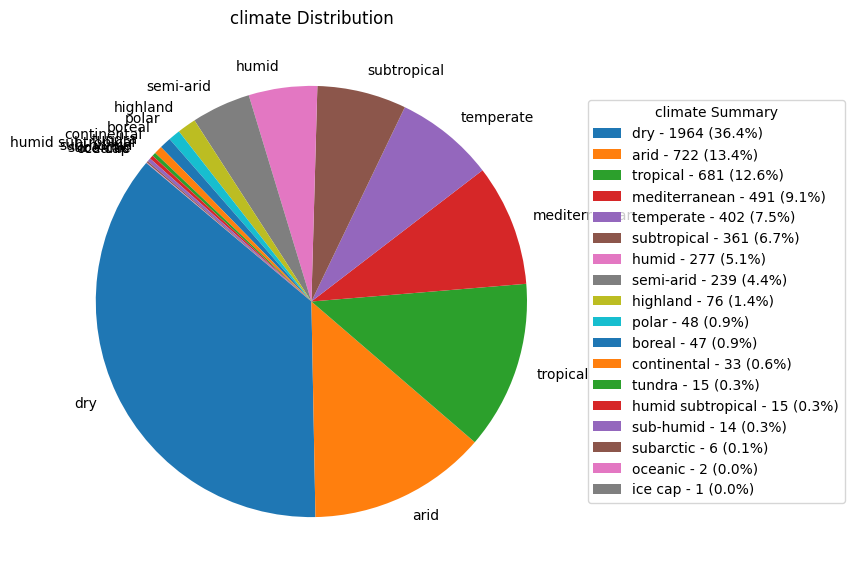

In [62]:
pie_chart_characteristics_legend('climate', dataset)


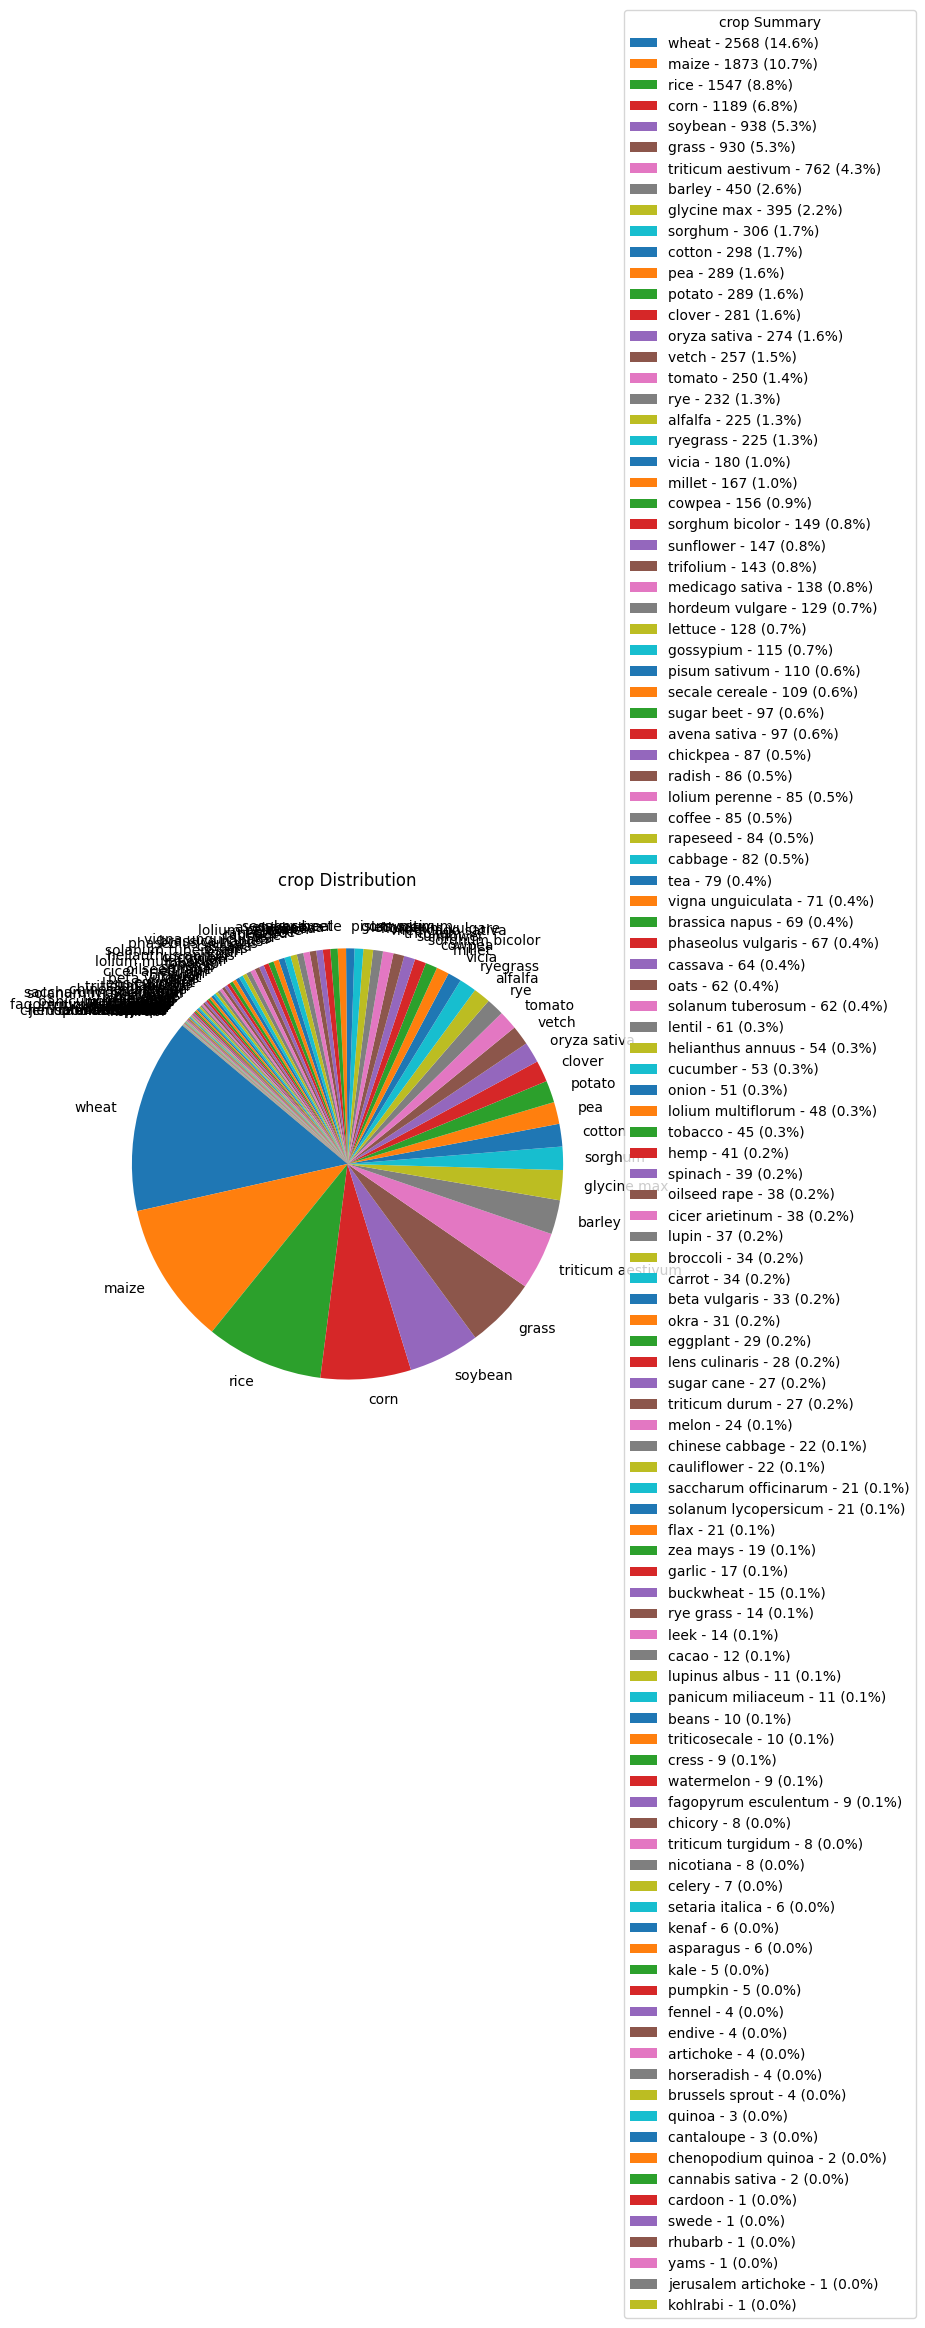

In [63]:
pie_chart_characteristics_legend('crop', dataset)

In [52]:
country_map('country',dataset)

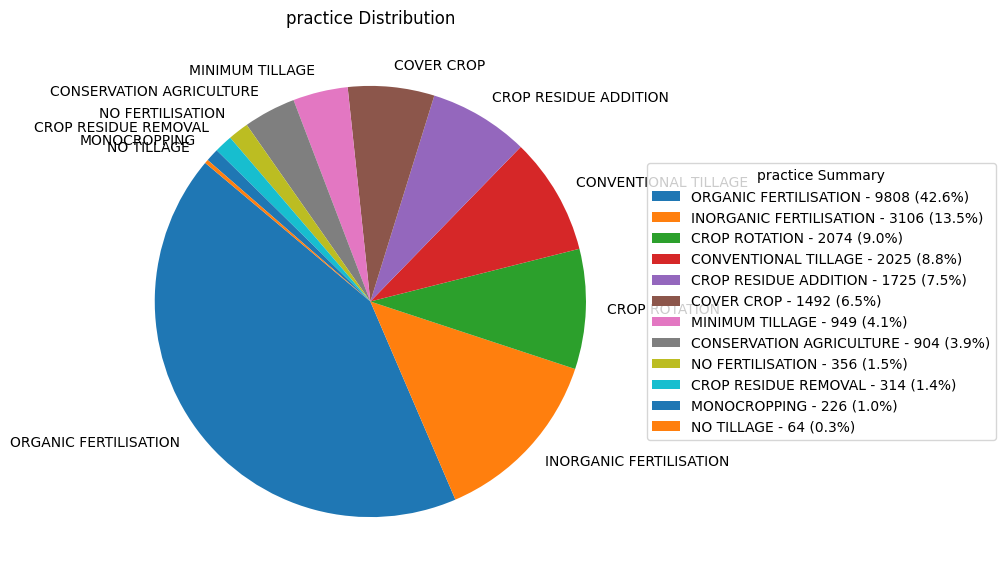

In [103]:
pie_chart_characteristics_legend('practice', dataset)

#Other Visualisation of the dataset


## Topic Modelling from abstracts

*   Showing the outcomes of the **topic distribution** among all abstracts present in dataset
*   Analyse the data to detect the 20 most common topics (key words that have the most probability to appear together) based on the lemmatized abstracts


In [ ]:
dataset.to_csv('/content/drive/MyDrive/Studia DSE/abstracts_lemmatized_topic_classified.csv', index=False)

<ipython-input-78-0afbf0d20fbd>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=number_counts.index, y=number_counts.values, palette='coolwarm')


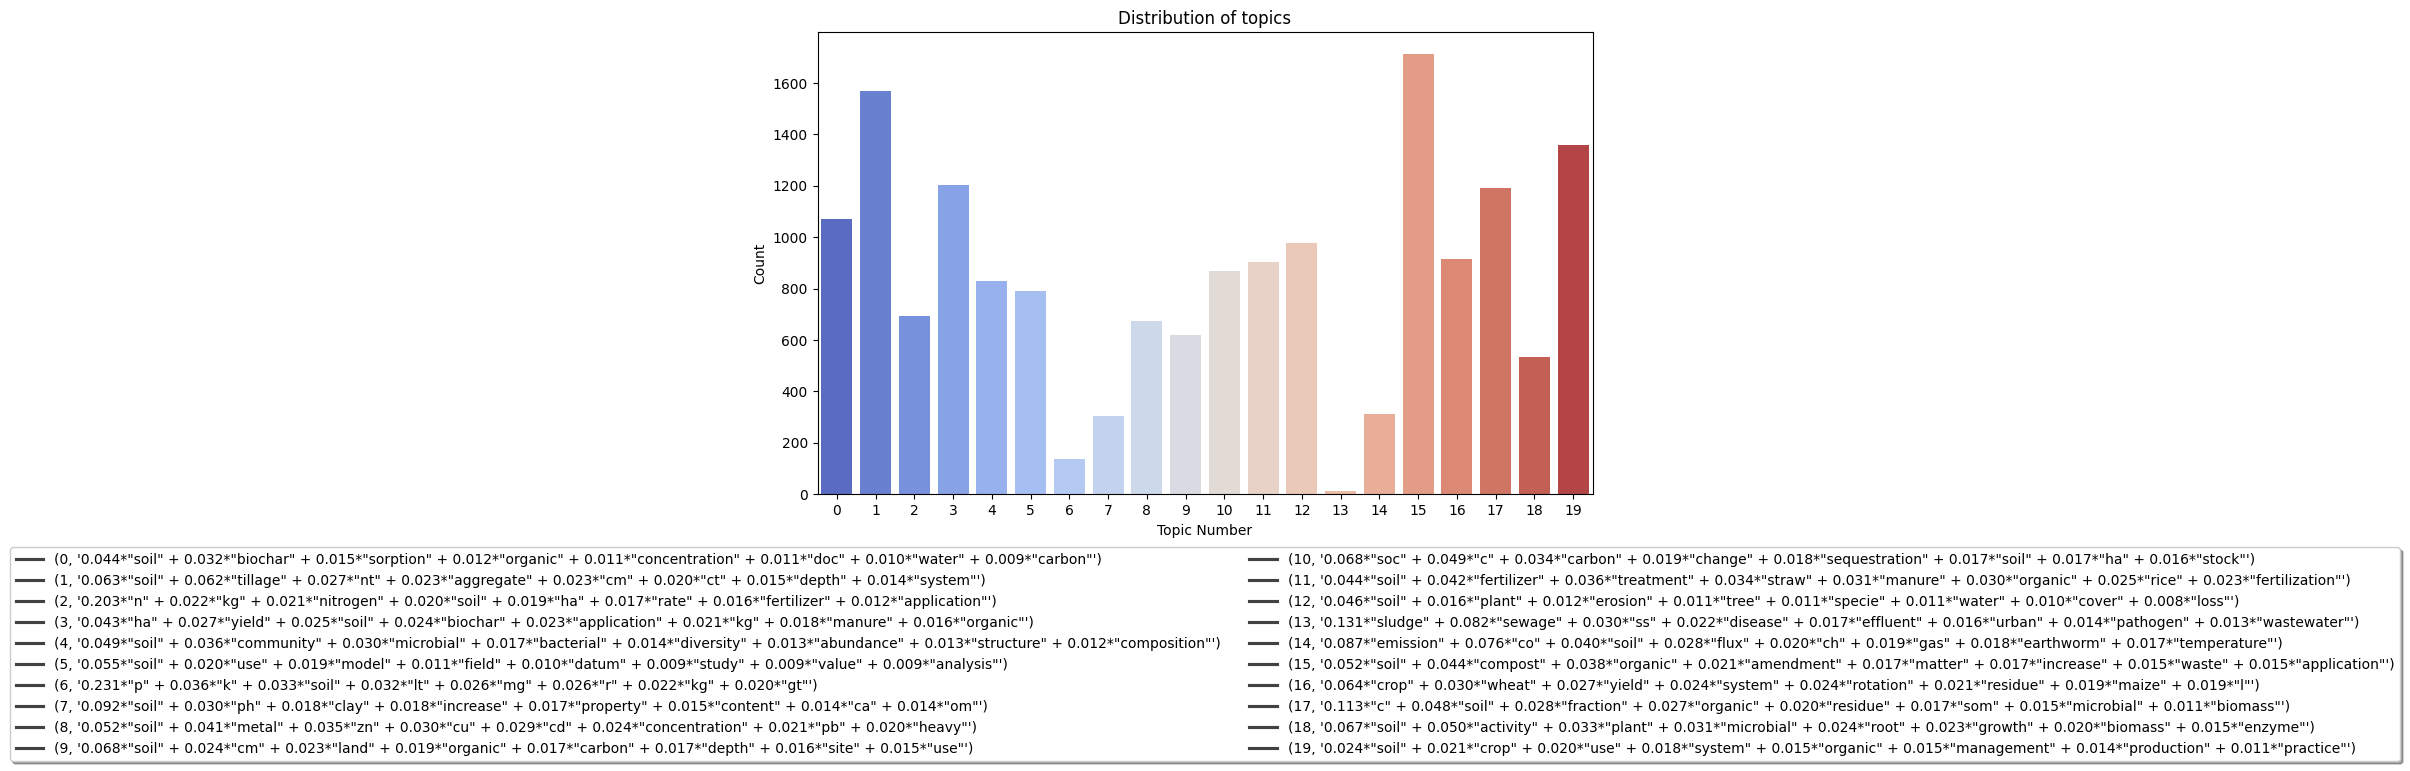

In [ ]:
number_counts = dataset['dominant_topic'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=number_counts.index, y=number_counts.values, palette='coolwarm')
plt.xlabel('Topic Number')
plt.ylabel('Count')
plt.title('Distribution of topics')
plt.xticks(range(20), range(0, 20))
plt.legend(topics, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
plt.show()

## Apriori Model for the word cloud


*   Visualising the frequency of the words within abstracts with support 0.25 and 0.5



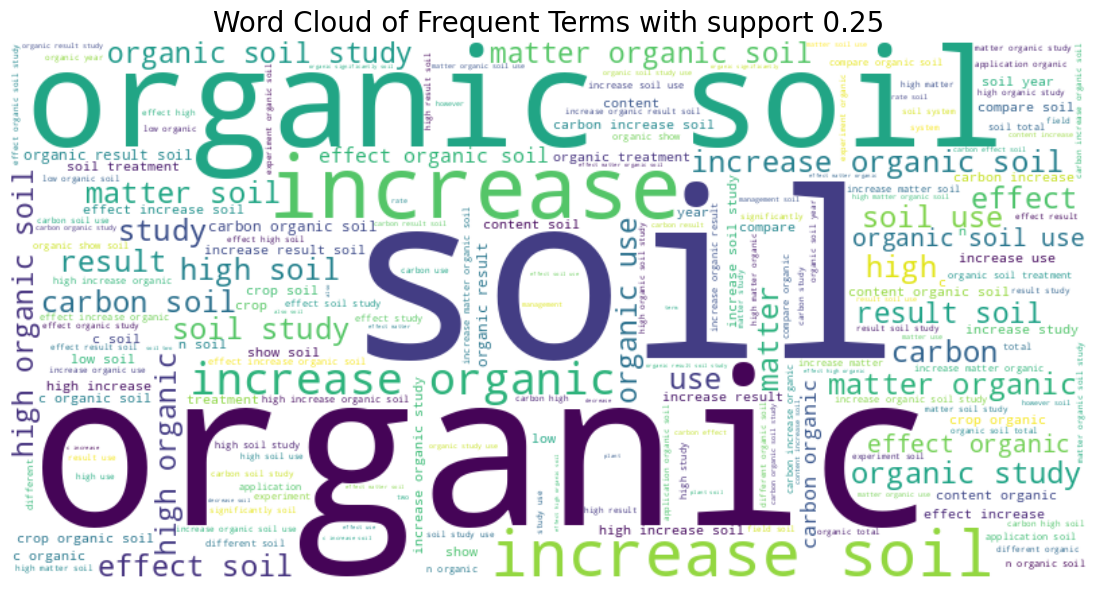

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(frequency_dict)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms with support 0.25', fontsize=20, color='black')
plt.show()






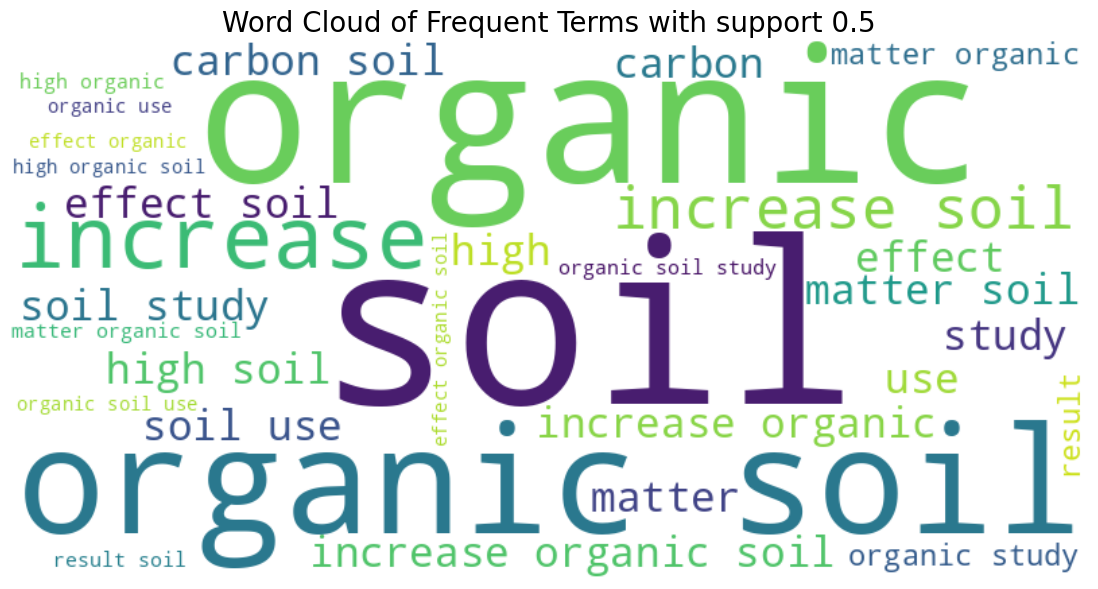

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(frequency_dict2)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms with support 0.5', fontsize=20, color='black')
plt.show()

# NO TILLAGE/ MINIMUM TILLAGE impact on the SOC


*   Split between positive, neutral and negative impact on SOC of Minimal and No tillage practice
*   Postive impact split based on characteristics



In [ ]:
columns_of_interest = ['All_SOC_Decrease', 'All_SOC_Increase', 'matches_neutral_SOC']

In [143]:
columns1= count_values_non_empty_column(columns_of_interest, filtered_NT_MT)

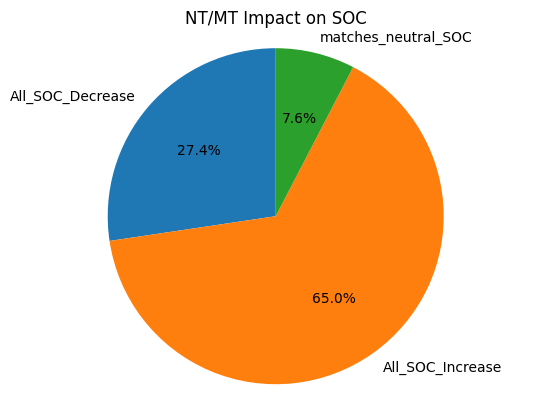

In [144]:
pie_chart_column_count (columns1, 'NT/MT Impact on SOC')

##Positive Impact of TL/NT on SOC analysis of characteristics

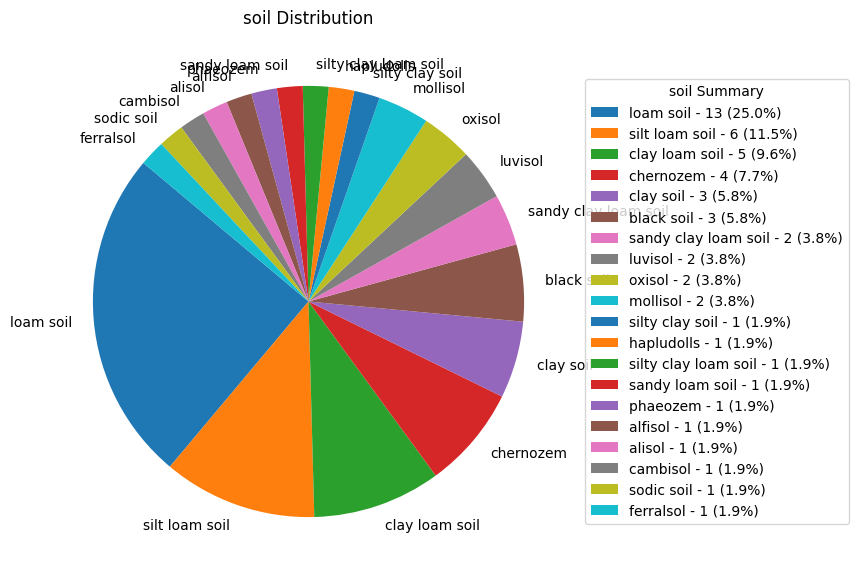

In [139]:
pie_chart_characteristics_legend('soil', filtered_NT_MT_plus)

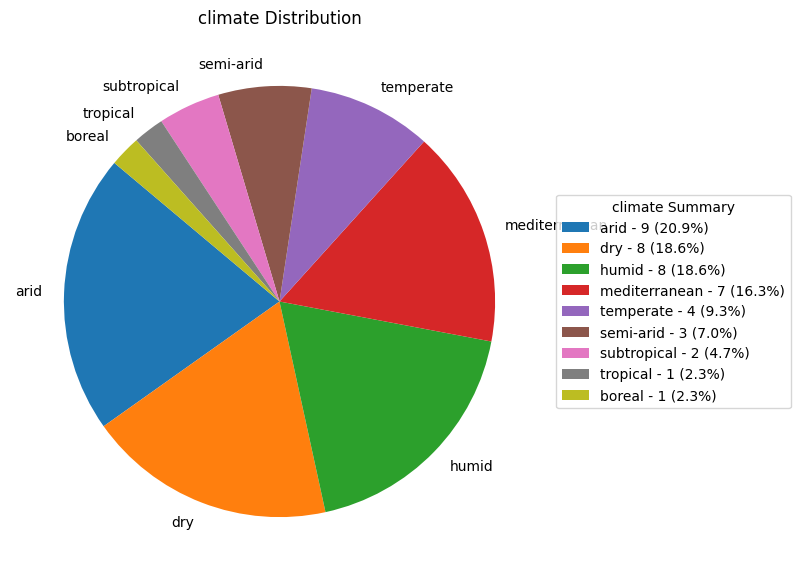

In [140]:
pie_chart_characteristics_legend('climate', filtered_NT_MT_plus)

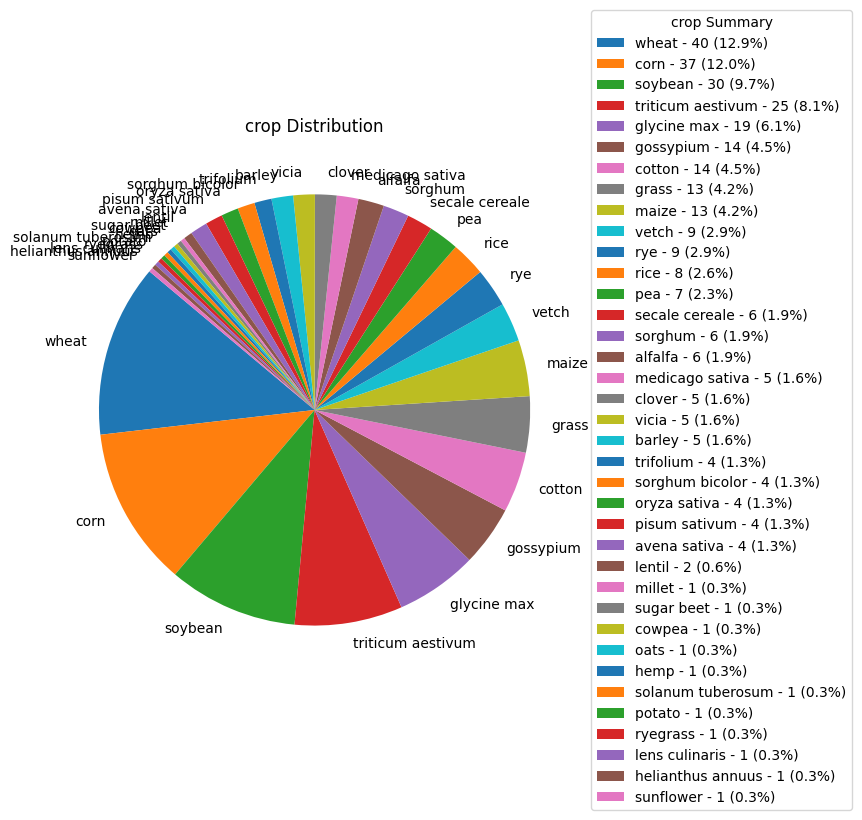

In [141]:
pie_chart_characteristics_legend('crop', filtered_NT_MT_plus)

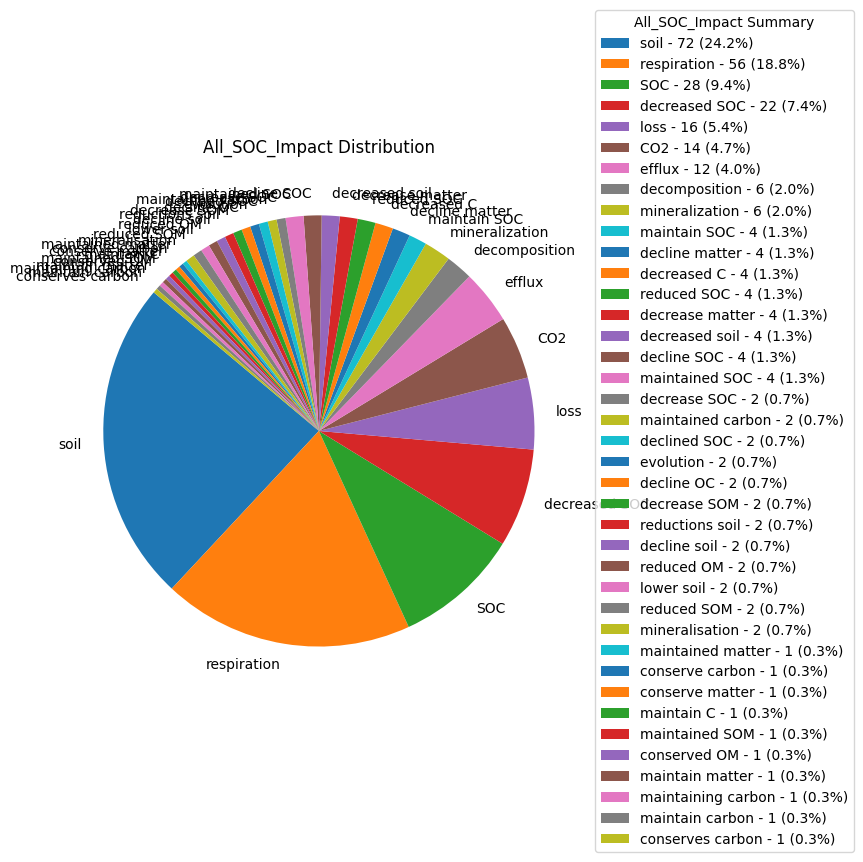

In [111]:
pie_chart_characteristics_legend('All_SOC_Impact', filtered_NT_MT)

In [107]:
labels2=['MINIMUM TILLAGE', 'NO TILLAGE']

In [126]:
dataset['NT_MT']= dataset['categories labels'].apply(lambda x: filter_label(x, labels2))

In [105]:
dataset['All_SOC_Impact'] = dataset.apply(lambda x: x['All_SOC_Decrease'] + x['All_SOC_Decrease'] + x['matches_neutral_SOC'] , axis=1)

In [76]:
dataset['All_SOC_Decrease'] = dataset.apply(lambda x: x['SOC_Decrease'] + x['matches_decrease_SOC'] , axis=1)

In [115]:
dataset['All_SOC_Increase'] = dataset.apply(lambda x: x['SOC_Increase'] + x['matches_increase_SOC'], axis=1)

In [129]:
filtered_NT_MT_plus= filtered_NT_MT[filtered_NT_MT['All_SOC_Increase'].apply(lambda x: len(x) > 0)]

In [122]:
filtered_NT_MT_plus = dataset[dataset['All_SOC_Increase'].apply(lambda x: len(x) > 0)]

In [77]:
filtered_SOC_decrease= dataset[dataset['All_SOC_Decrease'].apply(lambda x: len(x) > 0)]

In [145]:
dataset.to_csv('/content/drive/MyDrive/Studia DSE/all_data_combined.csv')